<H2>CUSTOMER LIFETIME VALUE PREDICTION </H2>

Companies invest in customers (acquisition costs, offline ads, promotions, discounts & etc.) to generate revenue and be profitable. Naturally, these actions make some customers super valuable in terms of lifetime value but, there are always some customers who pull down the profitability. 

In this project, I will be identifying these customer behavior patterns and segmenting the customers.

To calculate the Customer Lifetime Value is the easy part, one is required to select a time window. It can be anything like 3, 6, 12, 24 months. 

>**Lifetime Value: Total Gross Revenue - Total Cost**

The above equation gives the historical lifetime value. If there are customers having very high negative lifetime value historically, it could be too late to take an action.

I will be building a simple machine learning model that predicts our customers lifetime value.

<h3>Lifetime Value Prediction</h3>

* Define an appropriate time frame for Customer Lifetime Value calculation
* Identify the features to use to predict future and create them
* Calculate lifetime value (LTV) for training the machine learning model
* Build and run the machine learning model
* Check if the model is useful

**1. How to decide the timeframe**

Deciding the time frame really depends on your industry, business model, strategy and more. For some industries, 1 year is a very long period while for the others it is very short. In this project, I will be working with 6 months.

**2. Identifying the features for prediction**

RFM scores for each customer ID are the perfect candidates for feature set. To implement it correctly, I will need to split my dataset. I will take 3 months of data, calculate RFM and use it for predicting next 6 months. I will create two dataframes first and append RFM scores to them.

After the first two steps, I will then proceed to calculate CLTV and train and test the model.

- <a href='#1'>1. Importing necessary libraries and packages and reading files</a>
   - <a href='#1.1'>1.1 Feature Engineering</a>
- <a href='#2'>2. Recency</a>
   - <a href='#2.1'>2.1 Assigning a recency score </a>
   - <a href='#2.2'>2.2 Ordering clusters</a>
- <a href='#3'> 3. Frequency</a>
   - <a href='#3.1'>3.1 Frequency clusters</a>
- <a href='#4'>4. Revenue</a>
   - <a href='#4.1'>4.1 Revenue clusters</a>
- <a href='#5'>5. Overall score based on RFM Clustering</a>  
- <a href='#6'>6. Customer Lifetime Value </a>
   - <a href='#6.1'>6.1 Feature engineering</a>
- <a href='#7'>7. Machine Learning for CLTV</a>  


<a href=1.><h3>1. Importing relevant packages and libraries </h3></a>

In [1]:

#import libraries
from __future__ import division

from datetime import datetime, timedelta,date

# Data Manipulation libraries
import pandas as pd # for dataframes
import numpy as np

# Data Visualization libraries
import matplotlib.pyplot as plt # for plotting graphs
%matplotlib inline
import seaborn as sns # for plotting graphs
sns.set()


from sklearn.cluster import KMeans
from sklearn.metrics import classification_report,confusion_matrix

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Loading the data
data = pd.read_csv("retail_data.csv", encoding="unicode_escape", parse_dates=['Date'])
print("Total number of transactions happened in the given period: "+ str(data.shape[0]))
data.head(5)

Total number of transactions happened in the given period: 131706


,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,2016-02-01,2547,1,X52,0EM7L,1.0,3.13
1,2016-02-01,822,2,2ML,68BRQ,1.0,5.46
2,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35
3,2016-02-01,3719,4,0H2,549KK,1.0,5.59
4,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88


**Crucial data points:**
- Customer ID
- Unit Price
- Quantity
- Invoice Date
- Revenue = Active Customer Count * Order Count * Average Revenue per Order


In [3]:
# Checking datatypes, missing value, unique values

temp_data = pd.DataFrame(index=data.columns)
temp_data['data_type'] = data.dtypes
temp_data['missingvalues_count'] = data.isnull().sum()
temp_data['unique_count']  = data.nunique()

temp_data

,data_type,missingvalues_count,unique_count
Date,datetime64[ns],0,363
Customer_ID,int64,0,22625
Transaction_ID,int64,0,64682
SKU_Category,object,0,187
SKU,object,0,5242
Quantity,float64,0,83
Sales_Amount,float64,0,3233


<a href=2.1><h3>2.1 Feature Engineering </h3></a>

In [4]:
# Rename Sales Amount column to Revenue
data.rename(columns = {'Sales_Amount':'Revenue','Date':'TxnDate'}, inplace = True)
data.head()

,TxnDate,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Revenue
0,2016-02-01,2547,1,X52,0EM7L,1.0,3.13
1,2016-02-01,822,2,2ML,68BRQ,1.0,5.46
2,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35
3,2016-02-01,3719,4,0H2,549KK,1.0,5.59
4,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88


**Step:** Convert the "TxnDate" column from a string format to a datetime format using the "pd.to_datetime" function 

Converting the "TxnDate" column to datetime format, makes it easier to perform time-based analysis on the data. For example, it enables grouping and aggregating the data by day, week, month, or year. This will be useful for identifying trends, seasonality, and other patterns in the data that may be related to time.

In [5]:
#converting the type of Invoice Date Field from string to datetime.
data['TxnDate'] = pd.to_datetime(data['TxnDate'])

**Step:** Create a new column named "TxnYearMonth" that represents the year and month of each transaction as a single integer value.

This column will enable grouping and aggregating the data by year and month, which is useful for identifying trends and patterns over time.

In [6]:
#creating YearMonth field for the ease of reporting and visualization
data['TxnYearMonth'] = data['TxnDate'].map(lambda date: 100*date.year + date.month)

In [7]:
# Statistical summary of dataset
data.describe()

,Customer_ID,Transaction_ID,Quantity,Revenue,TxnYearMonth
count,131706.000000,131706.000000,131706.000000,131706.000000,131706.000000
mean,12386.450367,32389.604187,1.485311,11.981524,201606.654587
std,6086.447552,18709.901238,3.872667,19.359699,3.450619
min,1.000000,1.000000,0.010000,0.020000,201601.000000
25%,7349.000000,16134.000000,1.000000,4.230000,201604.000000
50%,13496.000000,32620.000000,1.000000,6.920000,201607.000000
75%,17306.000000,48548.000000,1.000000,12.330000,201610.000000
max,22625.000000,64682.000000,400.000000,707.730000,201612.000000


The describe() function displays various statistical measures such as count, mean, standard deviation, minimum, and maximum values for all the numerical columns present in the DataFrame. The output also shows the data type of each column, the number of missing values, and the number of unique values in each column.

**Observations:**
- Data: 131,706 transactions 
- Intefers: Customer_ID,Transaction_ID 
- Objects: SKU_Category,SKU 
- Float: Quantity,Sales_Amount 
- Average transaction: 1.49 
- Revenue: $11.98
- Maximum value: 400 (potential outlier)

**Segmentation Techniques**

Segmentations can be according to what one is trying to achieve. If you want to increase retention rate, segment based on churn probability. Another useful segmentation methods to a business is RFM Analysis.

**RFM** - Recency - Frequency - Monetary Value. It gives segments as below:

- *Low Value:* Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.
- *Mid Value:* Fairly frequent customers who generate moderate revenue.
- *High Value:* This is the group of customers a business doesnot want to lose. High Revenue, Frequency and low Inactivity.

As per above methodology, I need to calculate Recency, Frequency and Monetary Value (Revenue) and apply machine learning to identify different groups (clusters) for each.



<h3><a href=2>2. Recency</a></h3>

To calculate recency, find out the most recent purchase date of each customer and see how many days they are inactive for. After having the no. of inactive days for each customer, apply K-means* clustering to assign customers a recency score.

The recency calculation allows one to obsere when last the customer bought something.

In [8]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
user_data = pd.DataFrame(data['Customer_ID'].unique())
user_data.columns = ['Customer_ID']
user_data.head()

,Customer_ID
0,2547
1,822
2,3686
3,3719
4,9200


**Step:** Calculate the number of days between the customer's last transaction and the maximum date (most recent date)

In [9]:
#get the max purchase date for each customer and create a dataframe with it
max_txn = data.groupby('Customer_ID').TxnDate.max().reset_index()
max_txn.columns = ['Customer_ID','LastTxnDate']
max_txn.head()

,Customer_ID,LastTxnDate
0,1,2016-01-22
1,2,2016-06-19
2,3,2016-02-01
3,4,2016-11-07
4,5,2016-09-02


In [10]:
# Compare the last transaction of the dataset with last transaction dates of the individual customer IDs.
max_txn['Recency'] = (max_txn['LastTxnDate'].max() - max_txn['LastTxnDate']).dt.days
max_txn.head()

,Customer_ID,LastTxnDate,Recency
0,1,2016-01-22,344
1,2,2016-06-19,195
2,3,2016-02-01,334
3,4,2016-11-07,54
4,5,2016-09-02,120


In [11]:
#merge this dataframe to our new user dataframe
user_data = pd.merge(user_data, max_txn[['Customer_ID','Recency']], on='Customer_ID')
user_data.head()

,Customer_ID,Recency
0,2547,57
1,822,304
2,3686,60
3,3719,30
4,9200,118


<a href=2.1><h3> 2.1 Assigning a recency score</h3></a> 

Apply K-means clustering to assign a recency score. This tells us how many clusters we need for the to K-means algorithm. To find this, apply the Elbow Method. 

The Elbow Method simply tells the optimal cluster number for optimal inertia. 

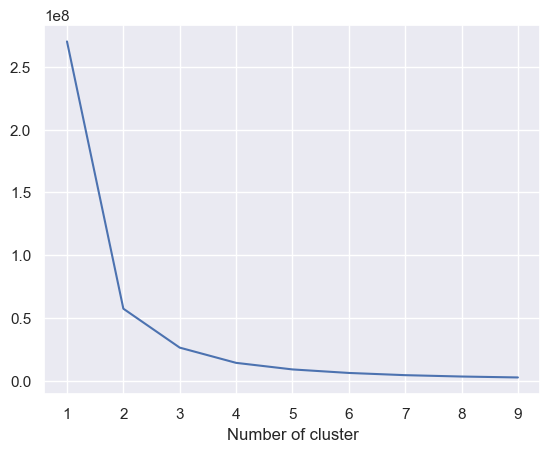

In [12]:
# Code snippet and Inertia graph
from sklearn.cluster import KMeans

sse={} # error
recency = user_data[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

**Elbow Method Steps**:

- Import the KMeans class from the sklearn.cluster module.
- Create an empty dictionary called SSE, to hold the sum of squared errors (SSE) for each number of clusters.
- Extract the recency column from the user_data df and store it in a new df called recency.
- Loop over a range of values from 1 to 10, and for each value, create a KMeans object with that number of clusters and fit it to the recency data.
- Add a new column to the recency df called 'clusters', which contains the cluster names corresponding to the recency values.
- Calculate the SSE for each number of clusters and store it in the sse dictionary with the number of clusters as the key.
- Finally, plot the number of clusters against the SSE to visualize the elbow point, which indicates the optimal number of clusters for the K-means algorithm.

**Observations:** 
The elbow point, which is the point of inflection on the curve where the SSE starts to level off. The optimal number of clusters is typically located at this point. Here, 3 is the optimal one. Based on business requirements, we can proceed with less or more clusters. 

*Note:* I will be using 4 clusters for this project for the recency data, based on the elbow of the curve in the SSE plot. This means that each customer is assigned to one of four clusters based on how recently they made a purchase.

In [13]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
user_data['RecencyCluster'] = kmeans.fit_predict(user_data[['Recency']])


In [14]:
#calculate mean recency and frequency for each recency cluster
user_data.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,4502.0,310.633496,28.220878,263.0,285.25,310.0,335.0,364.0
1,5407.0,113.901609,26.112557,73.0,91.00,110.0,137.0,164.0
2,4659.0,214.796952,28.577991,165.0,189.00,215.0,241.0,262.0
3,8057.0,31.298498,20.638219,0.0,13.00,29.0,48.0,72.0


**Observations:**
We have 4 recency clusters with the following mean values:
- Cluster 0: 311 days, 4476 users
- Cluster 1: 215 days, 4646 users
- Cluster 2: 115 days, 5372 users
- Cluster 3: 32 days, 8131 users

K-means clustering is a method of clustering that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. In this case, I used K-means clustering to assign a recency score to each customer.

The Elbow Method is a technique used to determine the optimal number of clusters to use in K-means clustering. The idea behind the Elbow Method is to identify the number of clusters where adding another cluster does not lead to a significant improvement in the model's performance. This can be done by plotting the number of clusters against the within-cluster sum of squares (inertia) and selecting the point where the curve starts to level off, which is known as the "elbow" of the curve.

In [15]:
user_data.head()

,Customer_ID,Recency,RecencyCluster
0,2547,57,3
1,822,304,0
2,3686,60,3
3,3719,30,3
4,9200,118,1


<a href=2.2><h3>2.2 Ordering clusters</a></h3>

As per our observations, a cluster corresponds to each customerID. But each cluster is randomly assigned. Cluster 2 is not better than cluster 1 for e.g. and so on. The next step is to give clusters according to most recent transactions.

**Steps:**
- Find the mean of recency value corresponding to each cluster. 
- Sort these values i.e. cluster 3 has the most recent transactions mean value. 
    From the above table we see that cluster 1(mean recency 304) > cluster 2 > cluster 3 > cluster 0. That means that cluster 1 is most inactive and cluster 0 is most recent. 
- Give indices to these clusters as 0,1,2,3. So cluster 1 becomes cluster 0, cluster 2 becomes cluster 1, cluster 3 becomes cluster 2 and so on. 
- Drop the original cluster numbers and replace them with 0,1,2,3.

In [16]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

user_data = order_cluster('RecencyCluster', 'Recency',user_data,False)

In [17]:
user_data.head()

,Customer_ID,Recency,RecencyCluster
0,2547,57,3
1,3686,60,3
2,3719,30,3
3,1666,0,3
4,1253,29,3


In [18]:
user_data.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,4502.0,310.633496,28.220878,263.0,285.25,310.0,335.0,364.0
1,4659.0,214.796952,28.577991,165.0,189.00,215.0,241.0,262.0
2,5407.0,113.901609,26.112557,73.0,91.00,110.0,137.0,164.0
3,8057.0,31.298498,20.638219,0.0,13.00,29.0,48.0,72.0


The clusters are arranged according to inactiviuty. Cluster 0 now is most inactive, cluster 3 is most active. 

<h3><a href=3>3. Frequency </a></h3>

To create frequency clusters, find the total number orders for each customer. 

In [19]:
#get order counts for each user and create a dataframe with it
frequency = data.groupby('Customer_ID').TxnDate.count().reset_index()
frequency.columns = ['Customer_ID','Frequency']

In [20]:
frequency.head() #how many orders does a customer have

,Customer_ID,Frequency
0,1,2
1,2,2
2,3,3
3,4,5
4,5,5


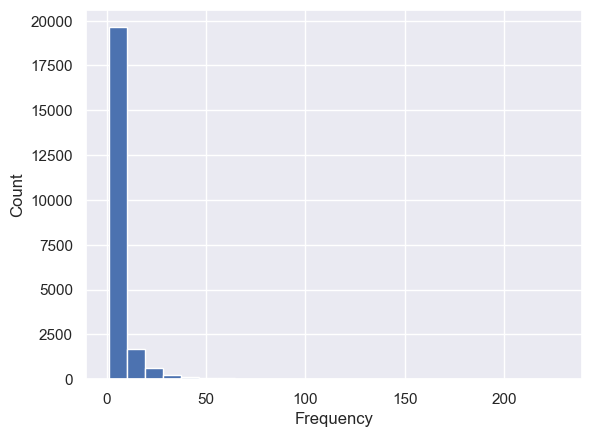

In [21]:
plt.hist(frequency['Frequency'], bins=25)
plt.xlabel('Frequency')
plt.ylabel('Count')
plt.show()

The Frequency column represents the total number of orders for each customer.

**Step:** Merge the frequency dataframe with user_data

In [22]:
#add this data to our main dataframe
user_data = pd.merge(user_data, frequency, on='Customer_ID')

user_data.head()

,Customer_ID,Recency,RecencyCluster,Frequency
0,2547,57,3,16
1,3686,60,3,50
2,3719,30,3,47
3,1666,0,3,109
4,1253,29,3,21


<a href=3.1><h3>3.1 Frequency clusters</h3></a>

Determine the right number of clusters for K-Means by elbow method

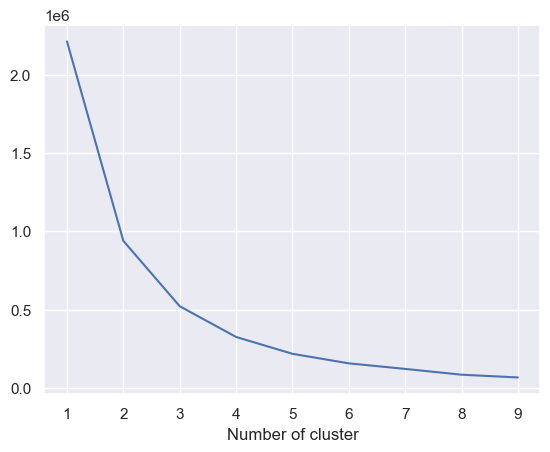

In [23]:
from sklearn.cluster import KMeans

sse={} # error
frequency = user_data[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(frequency)
    frequency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Based on the elbow plot, we can select 4 clusters for the frequency variable, as after 4, the graph goes down.

In [24]:
# Applying k-Means
kmeans=KMeans(n_clusters=4)
user_data['FrequencyCluster']=kmeans.fit_predict(user_data[['Frequency']])

#order the frequency cluster
user_data = order_cluster('FrequencyCluster', 'Frequency', user_data, True )
user_data.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,19226.0,2.969572,2.164871,1.0,1.0,2.0,4.0,9.0
1,2826.0,15.952229,5.505799,10.0,11.0,14.0,19.0,30.0
2,516.0,44.691860,11.855932,31.0,35.0,41.0,51.0,79.0
3,57.0,113.526316,36.884523,81.0,90.0,100.0,123.0,228.0


**Observations of the descriptive statistics for the frequency cluster:**
- count: number of customers in each frequency cluster
- mean: average frequency for each cluster
- std: standard deviation of the frequency values in each cluster

Cluster 0 has the lowest average frequency value of 2.97, which means that the customers in this cluster have the fewest number of orders, while cluster 3 has the highest average frequency of 113.53. The standard deviation also increases as we move from cluster 0 to cluster 3, which means that the frequency values are more spread out in the higher clusters.

Cluster with max frequency is cluster 3, least frequency cluster is cluster 0.

In [25]:
user_data.head()

,Customer_ID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,2547,57,3,16,1
1,1253,29,3,21,1
2,5541,29,3,30,1
3,6044,27,3,20,1
4,6179,57,3,20,1


<a href=4><h3>4. Revenue</h3></a>
How do our customer look like when we cluster them based on revenue? 

**Step:** 
Calculate revenue for each customer, plot a histogram and apply the same clustering method.

In [26]:
#calculate revenue for each customer
revenue = data.groupby('Customer_ID').Revenue.sum().reset_index()

In [27]:
#merge it with our main dataframe
user_data = pd.merge(user_data, revenue, on='Customer_ID')
user_data.head()


,Customer_ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,2547,57,3,16,1,121.36
1,1253,29,3,21,1,161.51
2,5541,29,3,30,1,392.53
3,6044,27,3,20,1,183.88
4,6179,57,3,20,1,215.80


**Elbow method to find out the optimum number of clusters for K-Means**

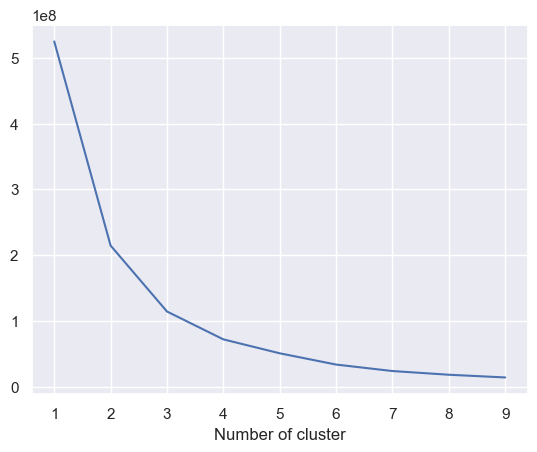

In [28]:
from sklearn.cluster import KMeans

sse={} # error
revenue = user_data[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(revenue)
    revenue["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

From elbow's method, we find that clusters can be 3 or 4. I'll use 4 as the number of clusters

<a href=4.1><h3> 4.1. Revenue clusters </h3></a>

In [29]:
#apply clustering
kmeans = KMeans(n_clusters=4)
user_data['RevenueCluster'] = kmeans.fit_predict(user_data[['Revenue']])

#order the cluster numbers
user_data = order_cluster('RevenueCluster', 'Revenue',user_data,True)

#show details of the dataframe
user_data.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,19674.0,29.789244,28.316849,0.14,8.9825,19.09,41.090,126.40
1,2339.0,222.583027,78.785889,126.50,157.1500,200.22,273.420,425.71
2,517.0,629.013810,167.629649,426.97,489.1200,579.03,748.330,1078.06
3,95.0,1538.349368,539.765830,1092.65,1181.4400,1427.39,1618.815,3985.94


Cluster 3 has max revenue, cluster 0 has lowest revenue

Now that I have recency, frequency, and revenue clusters, I will proceed to creating an overall score for each customer.

**Step:**
- Calculate the mean value of each cluster and multiply it by its weight to create a score for each customer. For example, if cluster 0 has a mean value of 1.5 for recency, 3 for frequency, and 20 for revenue, and we assign 40% weight to recency, 30% weight to frequency, and 30% weight to revenue, then the score for a customer in cluster 0 would be:

> Score = (1.5 * 0.4) + (3 * 0.3) + (20 * 0.3) = 6.1

- Rank the customers based on their scores to see who are our most valuable customers.

<a href=5><h3>5. Overall Score based on RFM Clustering</h3></a>

With the scores (cluster numbers) for recency, frequency & revenue, create an overall score out of them


In [30]:
#calculate overall score and use mean() to see details
user_data['RFM Score'] = user_data['RecencyCluster'] + user_data['FrequencyCluster'] + user_data['RevenueCluster']
user_data.groupby('RFM Score')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
RFM Score,,,
0,311.185538,2.238084,21.088891
1,217.514900,2.676899,27.833415
2,120.538430,3.299898,34.628273
3,43.019870,4.224734,43.435206
4,52.803446,12.486296,149.342506
5,29.381371,18.452548,235.640404
6,24.321767,31.753943,444.237161
7,19.967742,46.129032,672.698961
8,15.277778,70.430556,1255.058611


In [31]:
# top 10 customers based on overall score
user_data.sort_values('RFM Score', ascending=False).head(10)

,Customer_ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM Score
22589,1660,0,3,228,3,1429.91,3,9
22607,17292,23,3,81,3,1126.23,3,9
22605,17309,9,3,92,3,1695.38,3,9
22604,17968,10,3,159,3,2281.25,3,9
22603,15501,11,3,81,3,1163.80,3,9
22602,17974,11,3,102,3,1903.68,3,9
22601,17982,8,3,108,3,1824.34,3,9
22600,17354,2,3,128,3,1142.82,3,9
22598,17104,0,3,218,3,3844.97,3,9
22597,17061,0,3,143,3,2057.69,3,9


**Observations:** 
The top 10 customers based on the overall score are customers with high recency, high frequency, and high revenue. These customers seem to be loyal and valuable to the company as they have been making purchases frequently and recently, and have also spent a considerable amount of money.

Therefore, score 8 is our best customer, score 0 is our worst  customer.

In [32]:
user_data['Segment'] = 'Low-Value'
user_data.loc[user_data['RFM Score']>2,'Segment'] = 'Mid-Value' 
user_data.loc[user_data['RFM Score']>4,'Segment'] = 'High-Value' 

**Steps:**
- Add a new column to the user_data df called 'Segment' and assigns it the value 'Low-Value' for all customers. Then, using logical indexing, updates the value of 'Segment' for customers with an RFM Score greater than 2 to 'Mid-Value', and for customers with an RFM Score greater than 4 to 'High-Value'.

This creates three segments of customers based on their RFM Scores:
- Low-Value (RFM Score <= 2)
- Mid-Value (RFM Score > 2 and <= 4)
- High-Value (RFM Score > 4)

In [33]:
user_data

,Customer_ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM Score,Segment
0,2547,57,3,16,1,121.36,0,4,Mid-Value
1,8521,59,3,10,1,86.36,0,4,Mid-Value
2,2476,27,3,13,1,102.90,0,4,Mid-Value
3,5097,29,3,11,1,80.60,0,4,Mid-Value
4,5948,30,3,13,1,109.66,0,4,Mid-Value
...,...,...,...,...,...,...,...,...,...
22620,16783,15,3,90,3,1336.24,3,9,High-Value
22621,13407,21,3,105,3,1092.65,3,9,High-Value
22622,12213,14,3,84,3,1213.26,3,9,High-Value
22623,10812,17,3,95,3,1280.50,3,9,High-Value


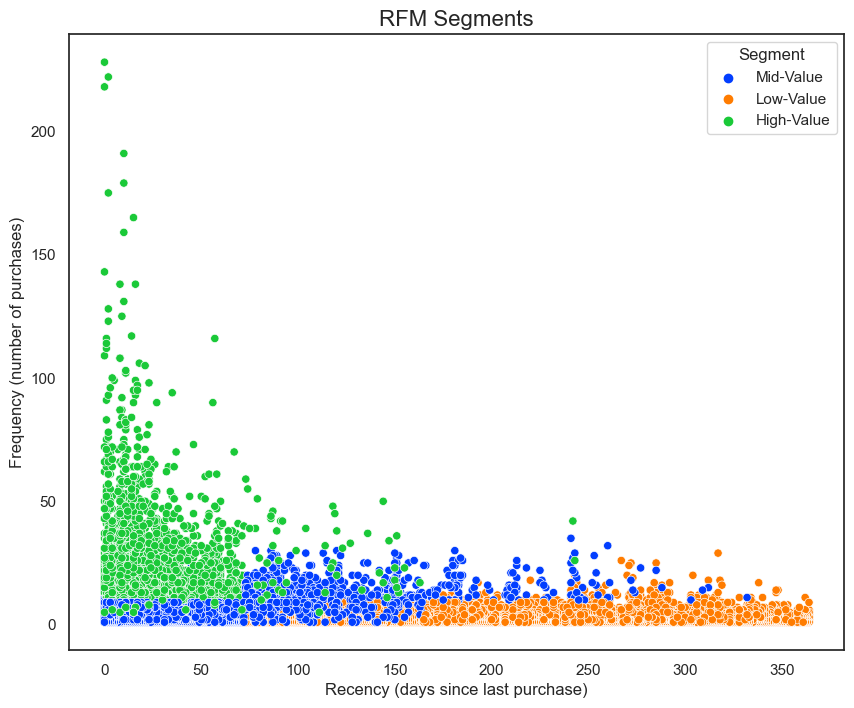

In [34]:
sns.set(style="white")

# Create scatter plot with segments colored by segment
plt.figure(figsize=(10, 8))
sns.scatterplot(data=user_data, x="Recency", y="Frequency", hue="Segment", palette="bright")
plt.title("RFM Segments", fontsize=16)
plt.xlabel("Recency (days since last purchase)", fontsize=12)
plt.ylabel("Frequency (number of purchases)", fontsize=12)
plt.show()


<a href=6><h3> 6. Customer Lifetime Value</a></h3>

With the feature set ready, calculate 6 months LTV for each customer which is to be used for training our model.

> **Lifetime Value: Total Gross Revenue - Total Cost**

There is no cost specified in the dataset hence Revenue becomes our LTV directly.


In [35]:
data.head()

,TxnDate,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Revenue,TxnYearMonth
0,2016-02-01,2547,1,X52,0EM7L,1.0,3.13,201602
1,2016-02-01,822,2,2ML,68BRQ,1.0,5.46,201602
2,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35,201602
3,2016-02-01,3719,4,0H2,549KK,1.0,5.59,201602
4,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88,201602


In [36]:
data['TxnDate'].describe()

count                  131706
unique                    363
top       2016-09-23 00:00:00
freq                      638
first     2016-01-02 00:00:00
last      2016-12-31 00:00:00
Name: TxnDate, dtype: object

**Observations:**
- Customers are active from 1 December 2010. 

    Consider customers from March onwards (so that they are not new customers). Divide them into 2 subgroups (One will be where timeframe of analysing is 3 months, another will be timeframe of 6 months.)

In [37]:
# extract transaction data for two different time periods, i.e., 3 months and 6 months.

data_3m = data[(data.TxnDate < datetime(2016,6,1)) & (data.TxnDate >= datetime(2016,3,1))].reset_index(drop=True) #3 months time
data_6m = data[(data.TxnDate >= datetime(2016,6,1)) & (data.TxnDate < datetime(2016,12,1))].reset_index(drop=True) # 6 months time

Calculate the total revenue generated by each customer during the 6-month period from June 2016 to November 2016, and creates a new df userdata_6m containing two columns - Customer_ID and M6_Revenue.

The assumption is that the data_6m df contains the order data for the 6 month period that is to be used to calculate LTV, and that the user_data df contains the customer information that we have been working with.

In [38]:
#calculate revenue and create a new dataframe for it
userdata_6m = data_6m.groupby('Customer_ID')['Revenue'].sum().reset_index()
userdata_6m.columns = ['Customer_ID','M6_Revenue']

In [39]:
userdata_6m.head()

,Customer_ID,M6_Revenue
0,2,15.00
1,4,33.29
2,5,20.13
3,8,9.78
4,12,21.00


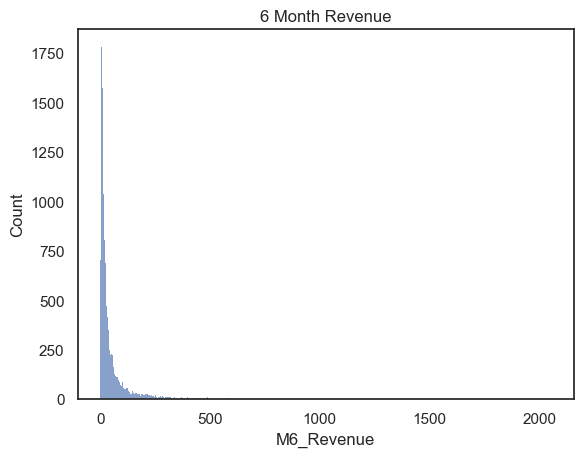

In [40]:
sns.histplot(userdata_6m['M6_Revenue'])
plt.title('6 Month Revenue')
plt.show()

**Observations:**
The histogram clearly shows there are customers with negative LTV. There are also some outliers. 

**Step:**
- Filter out the outliers to have a proper machine learning model
- Merge the datasets to see correlations between LTV and the feature set we have: user_data  userdata_6m 

In [41]:
user_data.head()

,Customer_ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM Score,Segment
0,2547,57,3,16,1,121.36,0,4,Mid-Value
1,8521,59,3,10,1,86.36,0,4,Mid-Value
2,2476,27,3,13,1,102.90,0,4,Mid-Value
3,5097,29,3,11,1,80.60,0,4,Mid-Value
4,5948,30,3,13,1,109.66,0,4,Mid-Value


In [42]:
data.head()

,TxnDate,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Revenue,TxnYearMonth
0,2016-02-01,2547,1,X52,0EM7L,1.0,3.13,201602
1,2016-02-01,822,2,2ML,68BRQ,1.0,5.46,201602
2,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35,201602
3,2016-02-01,3719,4,0H2,549KK,1.0,5.59,201602
4,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88,201602


In [43]:
data_merge = pd.merge(user_data, userdata_6m, on='Customer_ID', how='left') #Only people who are in the timeline of userdata_6m

In [44]:
# handle missing values before training a model
data_merge = data_merge.fillna(0)

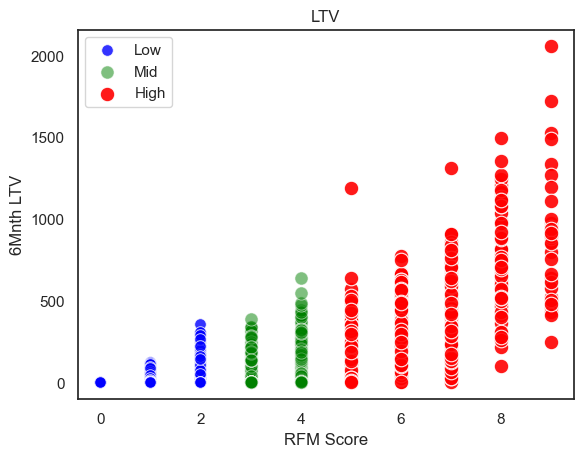

In [45]:
# visualize the relationship between the 6-month LTV and the RFM score for each customer segment
# filter out values where m6_Revenue < 50000
data_graph = data_merge.query("M6_Revenue < 50000")

# create subplots
fig, ax = plt.subplots()

# plot data points for each segment
sns.scatterplot(
    x=data_graph.query("Segment == 'Low-Value'")['RFM Score'],
    y=data_graph.query("Segment == 'Low-Value'")['M6_Revenue'],
    color='blue',
    alpha=0.8,
    s=70,
    ax=ax,
    label='Low'
)
sns.scatterplot(
    x=data_graph.query("Segment == 'Mid-Value'")['RFM Score'],
    y=data_graph.query("Segment == 'Mid-Value'")['M6_Revenue'],
    color='green',
    alpha=0.5,
    s=90,
    ax=ax,
    label='Mid'
)
sns.scatterplot(
    x=data_graph.query("Segment == 'High-Value'")['RFM Score'],
    y=data_graph.query("Segment == 'High-Value'")['M6_Revenue'],
    color='red',
    alpha=0.9,
    s=110,
    ax=ax,
    label='High'
)

# set x and y axis labels and title
ax.set_xlabel('RFM Score')
ax.set_ylabel('6Mnth LTV')
ax.set_title('LTV')

# show legend
ax.legend()

# display the plot
plt.show()


**Visualise correlation between overall RFM score and revenue.**
- Blue markers represent the Low-Value customers
- Green markers represent the Mid-Value customers
- Red markers represent the High-Value customers.

A positive correlation is quite visible: High RFM score means high LTV.

Before building the machine learning model, identify what is the type of this machine learning problem. 
- LTV is a regression problem: The machine learning model can predict the $ value of the LTV. But here, I want LTV segments. Because it makes it more actionable and easy to communicate with other people. By applying K-means clustering, I can identify the existing LTV groups and build segments on top of it.

Considering business part of this analysis, I need to treat customers differently based on their predicted LTV. For example, I will apply clustering and have 3 segments (number of segments really depends on your business dynamics and goals):
* Low LTV
* Mid LTV
* High LTV

I will then apply K-means clustering to decide segments and observe their characteristics

I also need to remove outliers using Seaborn. I will use the boxplot function to create a boxplot of the M6_Revenue column and then use the whis parameter to set the whisker length, which determines the range of the outliers.
    The whis parameter sets the length of the whiskers to 1.5 times the interquartile range (IQR), which is a common threshold for detecting outliers. Any data point outside the whiskers is considered an outlier and can be removed from the dataset. Modify the whis value to adjust the range of the whiskers if needed.

<Axes: xlabel='M6_Revenue'>

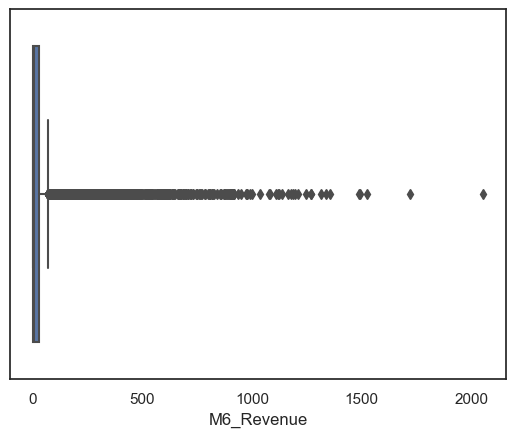

In [46]:
sns.boxplot(x=data_merge['M6_Revenue'], whis=1.5)

In [47]:
#remove outliers
data_merge = data_merge[data_merge['M6_Revenue']<data_merge['M6_Revenue'].quantile(0.99)]

In [48]:
data_merge.head()

,Customer_ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM Score,Segment,M6_Revenue
0,2547,57,3,16,1,121.36,0,4,Mid-Value,39.62
1,8521,59,3,10,1,86.36,0,4,Mid-Value,18.55
2,2476,27,3,13,1,102.90,0,4,Mid-Value,4.43
3,5097,29,3,11,1,80.60,0,4,Mid-Value,2.11
4,5948,30,3,13,1,109.66,0,4,Mid-Value,37.58


In [49]:
#creating 3 clusters
kmeans = KMeans(n_clusters=3)
data_merge['LTVCluster'] = kmeans.fit_predict(data_merge[['M6_Revenue']])

data_merge.head()

,Customer_ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM Score,Segment,M6_Revenue,LTVCluster
0,2547,57,3,16,1,121.36,0,4,Mid-Value,39.62,0
1,8521,59,3,10,1,86.36,0,4,Mid-Value,18.55,0
2,2476,27,3,13,1,102.90,0,4,Mid-Value,4.43,0
3,5097,29,3,11,1,80.60,0,4,Mid-Value,2.11,0
4,5948,30,3,13,1,109.66,0,4,Mid-Value,37.58,0


In [50]:
#order cluster number based on LTV
data_merge = order_cluster('LTVCluster', 'M6_Revenue',data_merge,True)

#creatinga new cluster dataframe
data_cluster = data_merge.copy()

#see details of the clusters
data_cluster.groupby('LTVCluster')['M6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,19060.0,9.742876,12.768667,0.00,0.0000,4.380,15.7125,51.29
1,2582.0,93.053892,35.143543,51.34,63.5400,83.015,115.9625,181.86
2,756.0,271.216561,70.023426,182.20,213.1475,251.225,315.5000,448.54


**Observation:**
Cluster 2 is the best with average 8.2k LTV whereas 0 is the worst with 396.

There are few more step before training the machine learning model:
* Feature engineering. 
* Convert categorical columns to numerical columns.
* Check the correlation of features against our label, LTV clusters.
* Split the feature set and label (LTV) as X and y. Use X to predict y.
* Create Training and Test dataset. Training set will be used for building the machine learning model. Apply the model to Test set to see its real performance.


In [51]:
data_cluster.head()

,Customer_ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM Score,Segment,M6_Revenue,LTVCluster
0,2547,57,3,16,1,121.36,0,4,Mid-Value,39.62,0
1,8521,59,3,10,1,86.36,0,4,Mid-Value,18.55,0
2,2476,27,3,13,1,102.90,0,4,Mid-Value,4.43,0
3,5097,29,3,11,1,80.60,0,4,Mid-Value,2.11,0
4,5948,30,3,13,1,109.66,0,4,Mid-Value,37.58,0


**Observations:**

The cluster number assigned to the customer is based on their lifetime value.

The LTVCluster assigns each customer to one of three clusters, based on their M6_Revenue (6-month revenue) value. Customers in Cluster 0 have the lowest M6_Revenue values, customers in Cluster 1 have medium M6_Revenue values, and customers in Cluster 2 have the highest M6_Revenue values.

<a href = 6.1> <h3>6.1 Feature Engineering</h3></a>

In [52]:
#convert categorical columns to numerical
data_class = pd.get_dummies(data_cluster) #There is only one categorical variable segment
data_class.head()

,Customer_ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM Score,M6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,2547,57,3,16,1,121.36,0,4,39.62,0,0,0,1
1,8521,59,3,10,1,86.36,0,4,18.55,0,0,0,1
2,2476,27,3,13,1,102.90,0,4,4.43,0,0,0,1
3,5097,29,3,11,1,80.60,0,4,2.11,0,0,0,1
4,5948,30,3,13,1,109.66,0,4,37.58,0,0,0,1


- pd.get_dummies(data_cluster) is performing one-hot encoding on the categorical variable "Segment", which means that it is converting the categorical variable into a set of binary variables. 
- In this case, the "Segment" variable has three possible values: "High-Value", "Mid-Value", and "Low-Value". Therefore, three new binary variables are created, one for each possible value. These new variables are named "Segment_High-Value", "Segment_Mid-Value", and "Segment_Low-Value". Each row will have a value of 1 for the binary variable corresponding to the value of the original "Segment" variable and 0 for the other binary variables. This allows for using the "Segment" variable in machine learning models that require numerical input.
- The resulting output, data_class, is the new df that includes the original features as well as the new binary variables created by one-hot encoding the "Segment" variable.

Calculate the correlation coefficients between the target variable LTVCluster and all other variables in the data_class dataset, and then sorts the correlations in descending order.

In [53]:
#calculate and show correlations
corr_matrix = data_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)


LTVCluster            1.000000
M6_Revenue            0.904664
Revenue               0.723379
RevenueCluster        0.681313
Frequency             0.659472
FrequencyCluster      0.623538
Segment_High-Value    0.616679
RFM Score             0.574507
RecencyCluster        0.310277
Customer_ID           0.152451
Segment_Mid-Value     0.052975
Recency              -0.316372
Segment_Low-Value    -0.377921
Name: LTVCluster, dtype: float64

**Observations:** 
- correlation coefficients of each variable with LTVCluster, with the variable having the highest correlation coefficient with LTVCluster listed first and so on, down to the variable having the lowest correlation coefficient with LTVCluster listed last. The higher the correlation coefficient, the more closely related the two variables are in terms of their linear association.

**Preparing the data for building a machine learning model to predict customer LTV.**

- create X and y variables. X is the feature set, which contains all columns except for LTVCluster and M6_Revenue. y is the label, which is the LTVCluster column.

- split data into training and testing sets. X_train and y_train are the training sets, which are used to train the machine learning model. X_test and y_test are the testing sets, which are used to evaluate the performance of the trained model on new, unseen data.

    The test_size parameter of 0.05 means that 5% of the data will be used for testing, and the random_state parameter is used to ensure that the data is split in the same way every time the code is run, which is useful for reproducibility.

In [54]:
#create X and y, X will be feature set and y is the label - LTV
X = data_class.drop(['LTVCluster','M6_Revenue'],axis=1)
y = data_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

<A href = 7><h3> 7. Machine Learning for CLTV </h3> </a>

Since the LTV Clusters are 3 types, high LTV, mid LTV and low LTV; perform multi class classification. 

In [55]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)


Accuracy of XGB classifier on training set: 0.94
Accuracy of XGB classifier on test set: 0.93


**Observation:** 

The accuracy of the XGBoost classifier model on the training and test sets is 0.94, which indicates good performance of the model. 

In [56]:
# check the precision, recall, fscore
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       961
           1       0.67      0.69      0.68       118
           2       0.69      0.83      0.76        41

    accuracy                           0.93      1120
   macro avg       0.78      0.83      0.80      1120
weighted avg       0.93      0.93      0.93      1120



The classification report shows various metrics related to the performance of the model. The report includes precision, recall, and F1-score for each class as well as the support (number of instances) for each class.

Precision measures how many instances were correctly classified as a certain class out of the total instances that the model classified as that class. Recall measures how many instances that truly belong to a certain class were correctly classified by the model. F1-score is the harmonic mean of precision and recall.

**Observations:**
- The XGBoost model has an accuracy of 94% on the test set. 
- Overall, the model has high precision and recall for the low LTV cluster (class 0) and lower precision and recall for the mid and high LTV clusters (classes 1 and 2).


**Precision:** is the number of true positive predictions (correctly predicted positive instances) divided by the total number of positive predictions. A high precision means that when the model predicts an instance as positive, it is likely to be correct.
    - Precision for cluster 0 is high at 0.98 which means when the model predicts an instance as high LTV, it is likely to be correct.
    - Precision for cluster 1 is moderate at 0.70 which means when the model predicts an instance as mid LTV, it has a moderate chance of being correct.
    - Precision for cluster 2 is moderate at 0.76 which means when the model predicts an instance as low LTV, it has a moderate chance of being correct.

**Recall:** is the number of true positive predictions divided by the total number of actual positive instances. A high recall means that the model is able to correctly identify most of the positive instances.
    - Recall for cluster 0 is high at 0.97 which means the model is able to correctly identify most of the high LTV instances.
    - Recall for cluster 1 is moderate at 0.76 which means the model is able to correctly identify some of the mid LTV instances.
    - Recall for cluster 2 is moderate at 0.78 which means the model is able to correctly identify some of the low LTV instances.


**F1-score:** is the harmonic mean of precision and recall. It provides a balance between precision and recall.
    - The F1-score for cluster 0 is high at 0.97 which indicates a good balance between precision and recall for high LTV.
    - The F1-score for cluster 1 is moderate at 0.73 which indicates a moderate balance between precision and recall for mid LTV.
    - The F1-score for cluster 2 is moderate at 0.77 which indicates a moderate balance between precision and recall for low LTV.

**Support:** is the number of instances in each class in the test set.

**Accuracy:** is the proportion of correctly classified instances among all the instances in the test set. Here, the model has an overall accuracy of 0.94 which means it correctly classifies 94% of the instances in the test set.

**Macro average:** calculates the average of precision, recall, and F1-score across all the classes.

**Weighted average:** calculates the average of precision, recall, and F1-score weighted by the number of instances in each class. This is useful when classes are imbalanced, and some classes have fewer instances than others.

- **Cluster 0**: Good precision, recall, f1-score and support
- **Cluster 1**: Needs better precision, recall and f1-score
- **Cluster 2**: Bad precision, F1-Score needs improvement

**Model Evaluation Scenario:**

 If the model tells states that a customer belongs to cluster 0, 98% will be correct (precision). And the model successfully identifies 97% of actual cluster 0 customers (recall).

**Step:** I need to improve the model for other clusters. For example, The model barely detects 70% of Mid LTV customers. 

**Possible actions to improve performance**

There are several possible actions to improve the performance of the model, some of which are:

- Hyperparameter tuning: Fine-tuning the parameters of the XGBoost model can improve its performance. This can be done using tools such as GridSearchCV or RandomizedSearchCV.

- Feature selection: Selecting the most important features that contribute significantly to the prediction can improve model performance. This can be done using techniques such as Recursive Feature Elimination (RFE), SelectKBest, or PCA.

- Handling imbalanced classes: Since the number of samples in each LTV cluster is not balanced, the model may be biased towards the majority class. Techniques such as oversampling (e.g., SMOTE) or undersampling can be used to balance the classes.

- Using ensemble methods: Ensembling different models can lead to better performance. This can be done using techniques such as stacking, where the predictions of multiple models are combined.

- Collecting more data: Collecting more data can improve model performance, especially if the data is representative of the population.

I used hyperparameter tuning using GridSearchCV, which is a technique for optimizing the parameters of a machine learning model.

**Steps:**
- defining a dictionary of hyperparameters and their possible values. These hyperparameters include 'max_depth', which controls the depth of each tree in the XGBoost model, 'learning_rate', which controls the step size during the optimization process, and 'n_estimators', which controls the number of trees in the ensemble.
- create an instance of the XGBClassifier model and an instance of the GridSearchCV class. The GridSearchCV class takes as input the model to be tuned, the hyperparameter dictionary, the number of cross-validation folds to use (in this case, 5), and the evaluation metric to optimize for (in this case, accuracy).
- fit the grid search object to the training data, which trains the XGBoost model for each combination of hyperparameters and evaluates its performance on the validation set. The best set of hyperparameters is the one that yields the highest accuracy score on the validation set.
- print out the best set of hyperparameters found by the grid search, as well as the corresponding accuracy score. These values can be used to train a final XGBoost model on the entire training set, using the optimal hyperparameters. This can potentially improve the model's performance on new, unseen data.

In [57]:
# Hyperparameter tuning using GridSearchCV:
from sklearn.model_selection import GridSearchCV

params = {'max_depth': [3, 4, 5],
          'learning_rate': [0.05, 0.1, 0.15],
          'n_estimators': [100, 200, 300]}

xgb_model = xgb.XGBClassifier()
grid_search = GridSearchCV(xgb_model, params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)


Best parameters found:  {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}
Best accuracy found:  0.9293633650813284


**Observations:**
- The line Best parameters found: {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 100} shows the optimal hyperparameters found by GridSearchCV. In this case, the best combination of hyperparameters includes a learning rate of 0.15, a maximum depth of 3, and 100 estimators.

- The line Best accuracy found: 0.9292225532986402 shows the highest accuracy achieved during the grid search process, which is 0.9292 or approximately 92.9%. This means that the model with the best hyperparameters achieved an accuracy of 92.9% on the validation set.

By using hyperparameter tuning, I improved the performance of my model by finding the best combination of hyperparameters that optimize the model's performance. In this project, the learning rate of 0.15, a maximum depth of 3, and 100 estimators were the best hyperparameters for this particular XGBoost model with an accuracy of 92.9%